# **MODULES AND FUNCTIONS**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/')

In [2]:
from functions import (continuous_delay, create_and_delay_pulse_pair, create_position, 
                       momentos, plot_gaussian, get_gaussian_params, calculate_gaussian_center_sigma)

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

train_data = np.load(os.path.join(dir,'Na22_train.npz'))['data']
val_data = np.load(os.path.join(dir, 'Na22_val.npz'))['data']
test_data = np.load(os.path.join(dir, 'Na22_test_val.npz'))['data']

In [4]:
# -------------------------------------------------------------------------
#----------------------- IMPORTANT DEFINITIONS ----------------------------
# -------------------------------------------------------------------------
         
delay_time = 1          # Max delay to training pulses in ns
time_step = 0.2         # Signal time step in ns
moments_order = 3       # Max order of moments used
nbins = 91              # Num bins for all histograms                   
t_shift = 1             # Time steps to move for the new positions
normalization_method = 'standardization'
start = 50
stop = 74

In [5]:
# -------------------------------------------------------------------------
#---------------------------- ALIGN PULSES --------------------------------
# -------------------------------------------------------------------------
align_time = 0.6
new_train = continuous_delay(train_data, time_step = time_step, delay_time = align_time, channel_to_fix = 0, channel_to_move = 1)
new_val = continuous_delay(val_data, time_step = time_step, delay_time = align_time, channel_to_fix = 0, channel_to_move = 1)
new_test = continuous_delay(test_data, time_step = time_step, delay_time = align_time, channel_to_fix = 0, channel_to_move = 1)


In [6]:
train_data = new_train[:,start:stop,:] 
validation_data = new_val[:,start:stop,:] 
test_data = new_test[:,start:stop,:]
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  18000
Número de casos de test:  3075


In [7]:
train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,:,0], time_step, delay_time = delay_time)
train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,:,1], time_step, delay_time = delay_time)

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(validation_data[:,:,0], time_step, delay_time = delay_time)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(validation_data[:,:,1], time_step, delay_time = delay_time)

TEST_00 = test_data 
TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift)
TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift)
TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift))
TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift))
TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)

REFERENCE_PULSE_dec0 = np.tile(TEST[0,:,0], (TEST.shape[0], 2, 1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(TEST[0,:,1], (TEST.shape[0], 2, 1)).swapaxes(1,2)

In [8]:
# Calculate moments 
M_Train_dec0 = momentos(train_dec0, order = moments_order) 
M_Train_dec1 = momentos(train_dec1, order = moments_order) 

M_Val_dec0 = momentos(val_dec0, order = moments_order) 
M_Val_dec1 = momentos(val_dec1, order = moments_order) 

MOMENTS_TEST = momentos(TEST, order = moments_order)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0, order = moments_order)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1, order = moments_order)

/home/josea/.local/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 63 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# **MODELS**

In [9]:
# Put train/validation data in appropiate form
train_data_dec0 = np.concatenate((M_Train_dec0[:,:,0], M_Train_dec0[:,:,1], REF_train_dec0[:, np.newaxis]), axis = 1)
train_data_dec1 = np.concatenate((M_Train_dec1[:,:,0], M_Train_dec1[:,:,1], REF_train_dec1[:, np.newaxis]), axis = 1)

val_data_dec0 = np.concatenate((M_Val_dec0[:,:,0], M_Val_dec0[:,:,1], REF_val_dec0[:, np.newaxis]), axis = 1)
val_data_dec1 = np.concatenate((M_Val_dec1[:,:,0], M_Val_dec1[:,:,1], REF_val_dec1[:, np.newaxis]), axis = 1)

test_data_dec0 =  np.concatenate((M_REF_dec0[:,:,0], MOMENTS_TEST[:,:,0]), axis = 1)
test_data_dec1 =  np.concatenate((M_REF_dec1[:,:,0], MOMENTS_TEST[:,:,1]), axis = 1)

# Save to a DataFrame 
train_data_dec0_df = pd.DataFrame(train_data_dec0, columns = ['M00','M01', 'M02', 'M03', 'M04', 'M10', 'M11', 'M12', 'M13', 'M14', 'ref'])
train_data_dec1_df = pd.DataFrame(train_data_dec1, columns = ['M00','M01', 'M02', 'M03', 'M04', 'M10', 'M11', 'M12', 'M13', 'M14', 'ref'])

val_data_dec0_df = pd.DataFrame(val_data_dec0, columns = ['M00','M01', 'M02', 'M03', 'M04', 'M10', 'M11', 'M12', 'M13', 'M14', 'ref'])
val_data_dec1_df = pd.DataFrame(val_data_dec1, columns = ['M00','M01', 'M02', 'M03', 'M04', 'M10', 'M11', 'M12', 'M13', 'M14', 'ref'])

test_data_dec0_df = pd.DataFrame(test_data_dec0, columns = ['M00','M01', 'M02', 'M03', 'M04', 'M10', 'M11', 'M12', 'M13', 'M14'])
test_data_dec1_df = pd.DataFrame(test_data_dec1, columns = ['M00','M01', 'M02', 'M03', 'M04', 'M10', 'M11', 'M12', 'M13', 'M14'])

In [10]:
from pycaret.regression import *
s0 = setup(train_data_dec0_df, target = 'ref', session_id = 123)
s1 = setup(train_data_dec1_df, target = 'ref', session_id = 123)

,Description,Value
0,Session id,123
1,Target,ref
2,Target type,Regression
3,Original data shape,"(18000, 7)"
4,Transformed data shape,"(18000, 7)"
5,Transformed train set shape,"(12600, 7)"
6,Transformed test set shape,"(5400, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,123
1,Target,ref
2,Target type,Regression
3,Original data shape,"(18000, 7)"
4,Transformed data shape,"(18000, 7)"
5,Transformed train set shape,"(12600, 7)"
6,Transformed test set shape,"(5400, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [11]:
models_dec0 = create_model('gbr')
models_dec1 = create_model('gbr')
tune_model(models_dec0)
tune_model(models_dec1)

print('')
print(models_dec0)
print(models_dec1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0230,0.0011,0.0331,0.9933,0.0212,0.3056
1,0.0223,0.0012,0.0339,0.9930,0.0247,0.4261
2,0.0230,0.0014,0.0376,0.9917,0.0250,0.2218
3,0.0212,0.0010,0.0315,0.9937,0.0228,0.3022
4,0.0225,0.0016,0.0396,0.9903,0.0224,1.1109
5,0.0223,0.0012,0.0343,0.9926,0.0225,0.2905
6,0.0214,0.0011,0.0331,0.9931,0.0206,0.2898
7,0.0228,0.0009,0.0298,0.9948,0.0220,0.2159
8,0.0240,0.0012,0.0352,0.9933,0.0224,0.3980


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0230,0.0011,0.0331,0.9933,0.0212,0.3056
1,0.0223,0.0012,0.0339,0.9930,0.0247,0.4261
2,0.0230,0.0014,0.0376,0.9917,0.0250,0.2218
3,0.0212,0.0010,0.0315,0.9937,0.0228,0.3022
4,0.0225,0.0016,0.0396,0.9903,0.0224,1.1109
5,0.0223,0.0012,0.0343,0.9926,0.0225,0.2905
6,0.0214,0.0011,0.0331,0.9931,0.0206,0.2898
7,0.0228,0.0009,0.0298,0.9948,0.0220,0.2159
8,0.0240,0.0012,0.0352,0.9933,0.0224,0.3980


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0159,0.0007,0.0260,0.9958,0.0157,0.2022
1,0.0161,0.0008,0.0289,0.9950,0.0207,0.2272
2,0.0175,0.0012,0.0351,0.9928,0.0175,0.1360
3,0.0152,0.0005,0.0228,0.9967,0.0160,0.1485
4,0.0161,0.0011,0.0326,0.9935,0.0194,0.9691
5,0.0156,0.0008,0.0287,0.9948,0.0184,0.1656
6,0.0155,0.0006,0.0244,0.9962,0.0183,0.1246
7,0.0158,0.0005,0.0226,0.9970,0.0156,0.1289
8,0.0177,0.0009,0.0297,0.9952,0.0167,0.2421


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0159,0.0007,0.0260,0.9958,0.0157,0.2022
1,0.0161,0.0008,0.0289,0.9950,0.0207,0.2272
2,0.0175,0.0012,0.0351,0.9928,0.0175,0.1360
3,0.0152,0.0005,0.0228,0.9967,0.0160,0.1485
4,0.0161,0.0011,0.0326,0.9935,0.0194,0.9691
5,0.0156,0.0008,0.0287,0.9948,0.0184,0.1656
6,0.0155,0.0006,0.0244,0.9962,0.0183,0.1246
7,0.0158,0.0005,0.0226,0.9970,0.0156,0.1289
8,0.0177,0.0009,0.0297,0.9952,0.0167,0.2421


Fitting 10 folds for each of 10 candidates, totalling 100 fits

GradientBoostingRegressor(random_state=123)
GradientBoostingRegressor(random_state=123)


In [12]:
# Get more detailed model evaluations
evaluate_model(models_dec0)
evaluate_model(models_dec1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## **FULL TOF**

In [13]:
# Get predictions
prediction_dec0 = predict_model(models_dec0, data = test_data_dec0_df)
prediction_dec1 = predict_model(models_dec1, data = test_data_dec1_df)

# Calculate TOF and extract the different positions
TOF = prediction_dec0['prediction_label'].to_numpy() - prediction_dec1['prediction_label'].to_numpy()

TOF_V02 = TOF[:TEST_00.shape[0]]
TOF_V00 = TOF[TEST_00.shape[0] : 2*TEST_00.shape[0]] 
TOF_V20 = TOF[2*TEST_00.shape[0] : 3*TEST_00.shape[0]] 
TOF_V04 = TOF[3*TEST_00.shape[0] : 4*TEST_00.shape[0]] 
TOF_V40 = TOF[4*TEST_00.shape[0]:]    

In [14]:
# Calculate errors
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOF_V00[None, :], np.zeros((TOF_V00[None, :].shape[0])), nbins = nbins) 

error_V02 = abs((TOF_V02 - centroid_V00 + time_step*t_shift))
error_V00 = abs((TOF_V00 - centroid_V00))
error_V20 = abs((TOF_V20 - centroid_V00 - time_step*t_shift))
error_V04 = abs((TOF_V04 - centroid_V00 + 2*time_step*t_shift))
error_V40 = abs((TOF_V40 - centroid_V00 - 2*time_step*t_shift))


Error = np.concatenate((error_V02, error_V20, error_V00, error_V04, error_V40))
MAE = np.mean(Error)
print(MAE)

0.48979719519608833


V40: CENTROID(ns) = -0.3868 +/- 0.00246  FWHM(ns) = 0.2482 +/- 0.00267
V20: CENTROID(ns) = -0.1973 +/- 0.00216  FWHM(ns) = 0.2605 +/- 0.00236
V00: CENTROID(ns) = 0.0001 +/- 0.00212  FWHM(ns) = 0.2263 +/- 0.00228
V02: CENTROID(ns) = 0.1923 +/- 0.00209  FWHM(ns) = 0.2289 +/- 0.00225
V04: CENTROID(ns) = 0.3864 +/- 0.00244  FWHM(ns) = 0.2439 +/- 0.00265



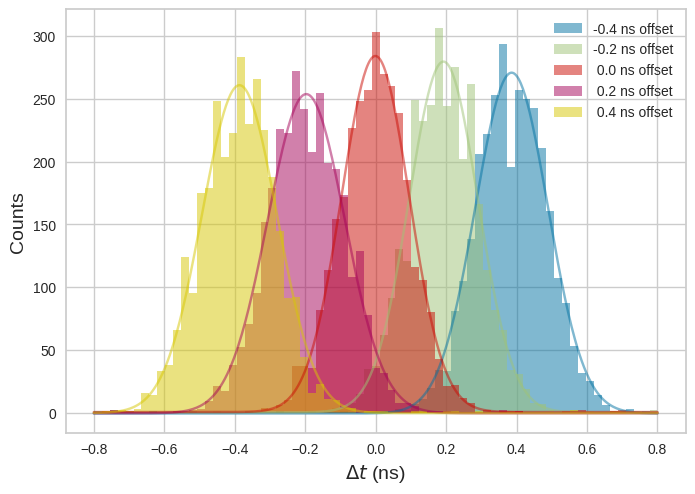

In [15]:
# Histogram and gaussian fit 
plot_gaussian(TOF_V04, centroid_V00, range = 0.8, label = '-0.4 ns offset', nbins = nbins - 20)
plot_gaussian(TOF_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins - 20)
plot_gaussian(TOF_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins - 20)
plot_gaussian(TOF_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins - 20)
plot_gaussian(TOF_V40, centroid_V00, range = 0.8, label = ' 0.4 ns offset', nbins = nbins - 20)


params_V04, errors_V04 = get_gaussian_params(TOF_V04, centroid_V00, range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOF_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20, centroid_V00, range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOF_V40, centroid_V00, range = 0.8, nbins = nbins)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()
